# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [155]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [156]:
# Read the Mapbox API key
load_dotenv("./Environment/.gitignore")
map_box_api = os.getenv("TOKEN_MAPBOX")

px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("./Data/sfo_neighborhoods_census_data.csv")
sfo_df = pd.read_csv(file_path, index_col="year")

csv_path = Path("./Data/neighborhoods_coordinates.csv")
coordinates_df = pd.read_csv(csv_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [144]:
# Define Panel Visualization Functions

# define function that returns Average Housing units per year
def housing_units_per_year():
    """Housing Units Per Year."""
    # Define the average housing from the dataframe
    avg_housing = sfo_df["housing_units"].groupby("year").mean()
    
    # Determine parameters necessary to center the plot
    avg_units = avg_housing.mean()
    std_units = avg_housing.std()
    # List of values for the y-ticker
    scale_plot = [round(avg_units-3*std_units, ndigits=-2), 
                  round(avg_units-2*std_units, ndigits=-2), 
                  round(avg_units-1*std_units, ndigits=-2),
                  round(avg_units, ndigits=-2),
                  round(avg_units+1*std_units, ndigits=-2),
                  round(avg_units+2*std_units, ndigits=-2),
                  round(avg_units+3*std_units, ndigits=-2)]
    
    # Min and max for the y axis
    min_plot= round(avg_units-4*std_units, ndigits=0)
    max_plot= round(avg_units+4*std_units, ndigits=0)
    
    # Sort values before plot
    avg_housing.sort_values(inplace=True)
    
    # Initialize new variable for the plot, create a figure from the plot using plt.figure()
    housing_units_fig = plt.figure()
    plot_units = avg_housing.plot(
        kind="bar",
        title="Housing units from 2010 to 2016",
        ylim=(min_plot,max_plot ),
        ylabel = "Housing Units",
        yticks=scale_plot,
        figsize=(10,5)
        )
    plt.close(housing_units_fig)
    
    # return pane with the figure plot_units
    return pn.pane.Matplotlib(housing_units_fig)



# define function that returns Average Housing units per year
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    # Calculate the average rent price per year
    avg_rent_cost = sfo_df[ "gross_rent"].groupby("year").mean()

    # Define plot for the average rent price per year, create a figure from the plot using plt.figure()
    rent_units_fig = plt.figure()

    plt_rent = avg_rent_cost.plot(
        title="Average Gross Rent by Year",
        ylabel = "Price per SqFt",
        color='red',
        xlabel="year",
        figsize=(10,5)
        )
    plt.close(rent_units_fig)
    
    # return pane with the figure plt_rent
    return pn.pane.Matplotlib(rent_units_fig)
    
    
# define function that returns Average sales price per square foot per year
def average_sales_price():
    """Average Sales Price Per Year."""
    # Calculate the average sales price per year
    avg_sales_cost = sfo_df["sale_price_sqr_foot"].groupby("year").mean()
    
    # Define plot for the average sales price per year, create a figure from the plot using plt.figure()
    sales_units_fig = plt.figure()
    plt_sales = avg_sales_cost.plot(
        title = "Average Price per sqFt by Year",
        ylabel = "Price per SqFt",
        xlabel="year",
        figsize=(10,5)
        )
    plt.close(sales_units_fig)
    
    # return pane with the figure plt_sales
    return pn.pane.Matplotlib(sales_units_fig)


# define function that returns  Average sales price per square foot per year and per neighborhood
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    # Calculate the average sales price per neighborhood and per year
    avg_neighborhood = sfo_df.groupby(["year", "neighborhood"]).mean().reset_index()
    
    # Define plot for the average sales price per neighborhood and per year    
    plt_sales_neighborhood = avg_neighborhood[["sale_price_sqr_foot", "year","neighborhood" ]].hvplot(
        x='year',
        y='sale_price_sqr_foot',
        ylabel ="Avg. Sale Price per Square Foot",
        groupby="neighborhood",
        width=800,
        height=400)
    return plt_sales_neighborhood


# define function that returns the ranking of the 10 most expensive neighborhood concerning the sales price
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    # Calculate the 10 most expensive neighborhood sales price for last years
    expnsif_sales = sfo_df.groupby("neighborhood").mean().nlargest(10,"sale_price_sqr_foot").reset_index() 
    
    # Define plot for 10 most expensive neighborhood sales price for last years
    plt_expensif_sales = expnsif_sales[["sale_price_sqr_foot","neighborhood"]].hvplot(
        kind="bar",
        x ="neighborhood",               
        xlabel="Neighborhood",
        rot=90,
        y ="sale_price_sqr_foot",                 
        ylabel="Avg. Rent Price per Square Foot",
        title = "TOP 10 Expensive Neghborhoods in SFO",
        width=800,
        height=450)
    return plt_expensif_sales


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods.""" 
    # Calculate the average prices per neighborhood and per year
    avg_neighborhood = sfo_df.groupby(["year", "neighborhood"]).mean().reset_index()
    
    # Calculate the 10 most expensive neighborhood sales price for last years
    expnsif_sales = sfo_df.groupby("neighborhood").mean().nlargest(10,"sale_price_sqr_foot").reset_index() 
    
    # Define plot average prices (rent and sales) for th most expensive neighborhoods for last years
    purchase_rent = avg_neighborhood[avg_neighborhood["neighborhood"].isin(expnsif_sales["neighborhood"])].drop(columns= "housing_units").set_index("year")

    # Define comparison plot for 10 most expensive neighborhood for last years   
    plt_expensif_rent= purchase_rent.hvplot(
        kind="bar",
        stacked= False,
        title =" Evolution prices per Neighborhood",
        xlabel = "Neighborhood",
        ylabel =" Price per Units",
        groupby="neighborhood",
        width=800,
        height=400,
        rot=90)
    return plt_expensif_rent
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    # Calculate the 10 most expensive neighborhood sales price for last years
    expnsif_sales = sfo_df.groupby("neighborhood").mean().nlargest(10,"sale_price_sqr_foot").reset_index() 
    
    plt_coordinates =px.parallel_coordinates(
        expnsif_sales,
        dimensions = ["sale_price_sqr_foot", "housing_units" , "gross_rent"],
        color = "sale_price_sqr_foot",
        labels= {
            "sale_price_sqr_foot": "Sale Price per Sqr Foot",
            "housing_units" : "Housing Units",
            "gross_rent" : "Rent price"
            },
        title = "Parallel Coordinates Analysis of most Expensive San Fransisco neighborhood" 
        )    
    return plt_coordinates


def parallel_categories():
    """Parallel Categories Plot."""
    # Calculate the 10 most expensive neighborhood sales price for last years
    expnsif_sales = sfo_df.groupby("neighborhood").mean().nlargest(10,"sale_price_sqr_foot").reset_index() 
    
    expnsif_sales["sale_price_sqr_foot"] = round(expnsif_sales["sale_price_sqr_foot"], 2)
    expnsif_sales["gross_rent"] = round(expnsif_sales["gross_rent"], 2)

    plt_categories = px.parallel_categories(
        expnsif_sales,
        dimensions =["neighborhood" ,"sale_price_sqr_foot", "housing_units" , "gross_rent"],
        title = "Parallel Categories Analysis of most Expensive San Fransisco neighborhood",
        color="sale_price_sqr_foot",
        color_continuous_scale= px.colors.sequential.Inferno,
        labels= {
            "neighborhood" : "Neighborhood",
            "sale_price_sqr_foot": "Sale Price per Sqr Foot",
            "housing_units" : "Housing Units",
            "gross_rent" : "Rent price"
            }
        )
    return plt_categories



def neighborhood_map():
    """Neighborhood Map."""
    # Calculate the mean values for each neighborhood
    neigh_data = sfo_df.groupby("neighborhood").mean().reset_index()
    
    # Join the average values with the neighborhood locations
    combined_df = pd.concat([coordinates_df, neigh_data], axis="columns", join="inner").drop(columns="neighborhood")
    
    map_plot = px.scatter_mapbox(
    combined_df,
    lat="Lat",
    lon="Lon",
    title = "Average Sales price per Square Foot and gross Rent in San Fransisco",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale = "icefire",
    height = 800,
    zoom = 10)

    return map_plot
    

def sunburst():
    """Sunburst Plot."""
    # Calculate the 10 most expensive neighborhood sales price for last years
    expnsif_sales = sfo_df.groupby("neighborhood").mean().nlargest(10,"sale_price_sqr_foot").reset_index() 
    
    # Calculate the average rent for the most expensives neighborhood
    df_expensive_neighborhoods_per_year = sfo_df[sfo_df["neighborhood"].isin(expnsif_sales["neighborhood"]) ].groupby(["year", "neighborhood"]).mean().drop(columns= ["housing_units", "sale_price_sqr_foot"]).reset_index()

    # Define Sunburst plot for the rent per neighborhood and per year
    plt_sunburst = px.sunburst(
        df_expensive_neighborhoods_per_year,
        path = ["year", "neighborhood" ],
        values = "gross_rent",
        color = "gross_rent",
        color_continuous_scale = "blues",
        height = 600,
        title = "Cost Analysis of most Expensive Neighborhoods in San Franscico")
    return plt_sunburst


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [145]:

# Create the columns for the tab layout (there are 5 different columns that show different figures)
fist_column = pn.Column(
    "This Dashboard shows some intresing analysis for the real estate market in San Fransisco.The first panel of this dashboard gives a general idea about the market evolution. Secondly we focus on the most expensive neighborhoods.",
    neighborhood_map()
    )


market_column = pn.Row(
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price()
    )



neighborhood_column = pn.Column(
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
    most_expensive_neighborhoods_rent_sales()
    )


parallel_column = pn.Column(
    parallel_categories(),
    parallel_coordinates(),
    )


sunburst_column = pn.Column(sunburst())

# Create the dashboard with the 5 columns
dashboard = pn.Tabs(
    ("Welcome" , fist_column),
    ("Yearly Market Analysis", market_column),
    ("Neighborhood Analysis", neighborhood_column),
    ("Parallel Plots Analysis", parallel_column),
    ("Sunburst Plot Analysis", sunburst_column)
    )

# Create a Title for the Dashboard to finalize the Dashboard for publication.
dashboard_out = pn.Column(
    "# Real Estate analysis for San Fransisco for the periode 2010- 2016",
    dashboard)



## Serve the Panel Dashboard

Traceback (most recent call last):
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\panel\viewable.py", line 273, in _on_msg
 doc.unhold()
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\util\callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\panel\reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\panel\reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 520, in caller
 return function()
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 351, in _depends
 return func(*args,**kw)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\panel\pane\plotly.py", line 153, in _update_figure_layout
 self._figure.plotly_relayout(self.relayout_data)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\plotly\basedatatypes.py", line 2601, in plotly_relayout
 relayout_changes = self._perform_plotly_relayout(relayout_data)
 File "C:\Users\Thom\anaconda3\envs\pyvizenv\lib\site-packages\plotly\basedatatypes.py", line 2641, in _perform_plotly_relayout
 key_path_str=key_path_str
ValueError: 
Invalid property path 'mapbox._derived' for layout

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                    [1] VSpacer()
        [3] Column
            [0] Plotly(Figure, visible=False)
            [1] Plotly(Figure, visible=False)
        [4] Column
            [0] Plotly(Figure, visible=False)
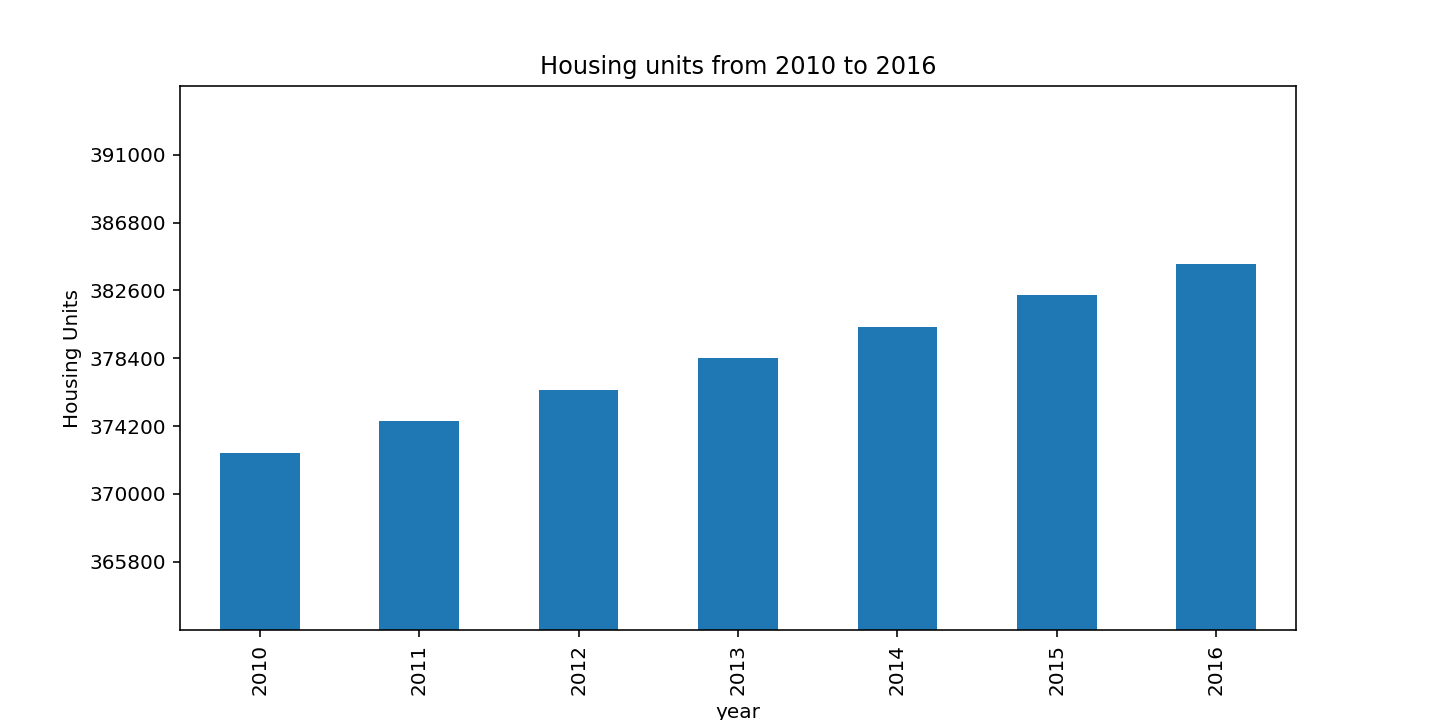
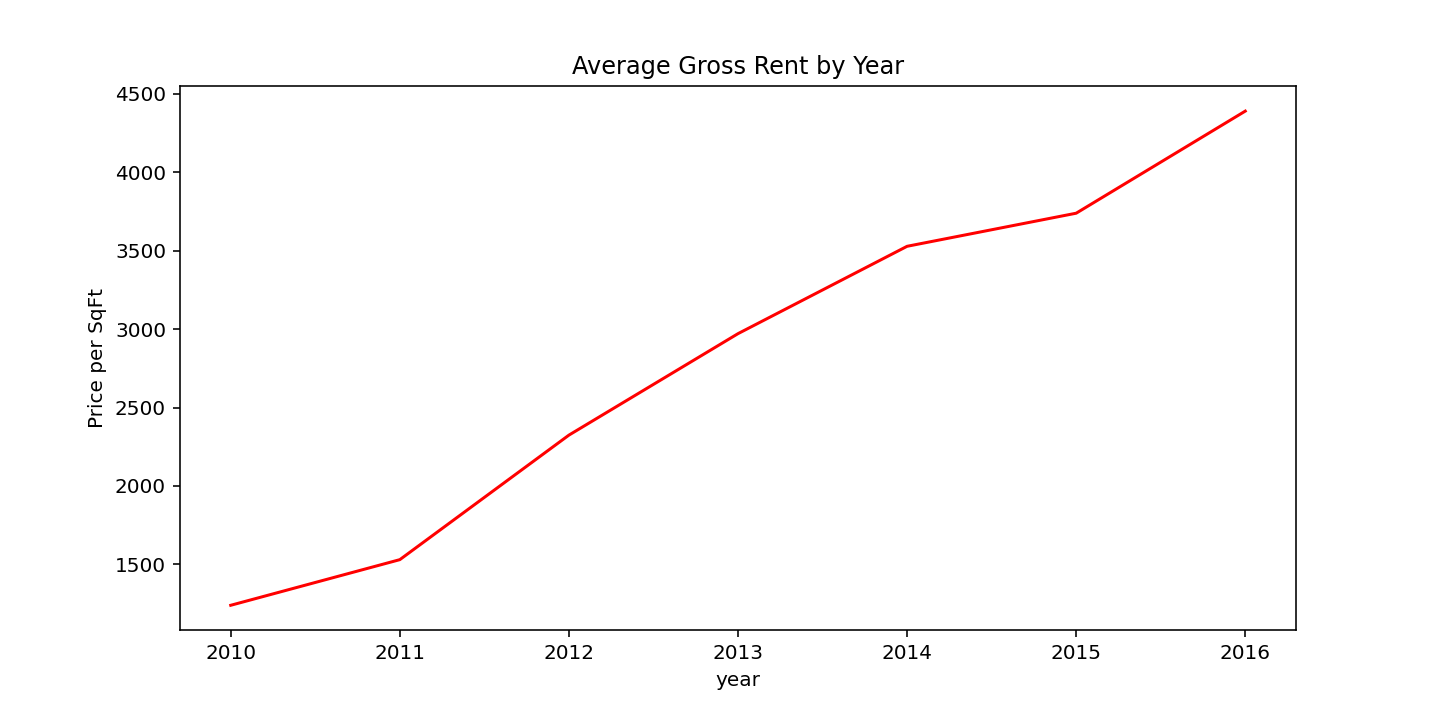
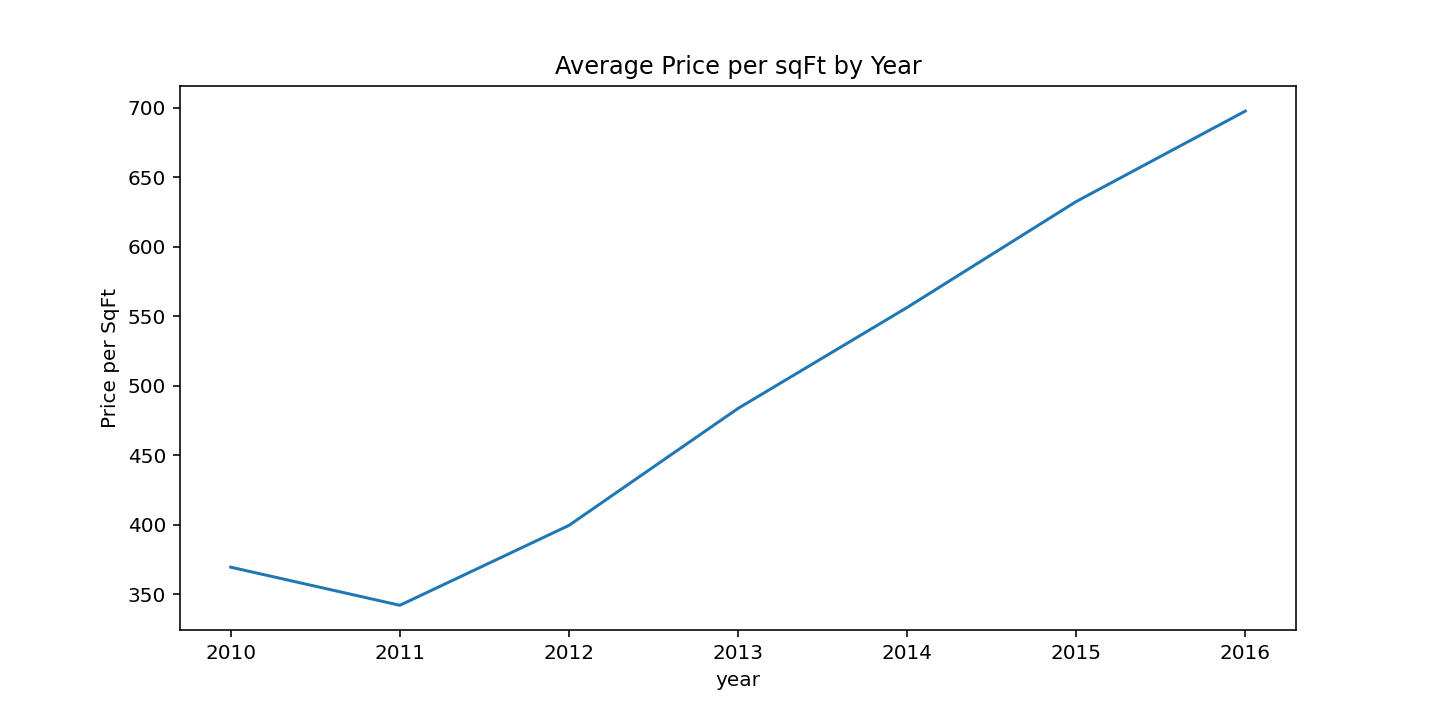

In [146]:
# Put the dashboard on the server
dashboard_out.servable()

In [ ]:
# Serve the# dashboard
# YOUR CODE HERE!

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

<AxesSubplot:title={'center':'Housing units from 2010 to 2016'}, xlabel='year', ylabel='Housing Units'>

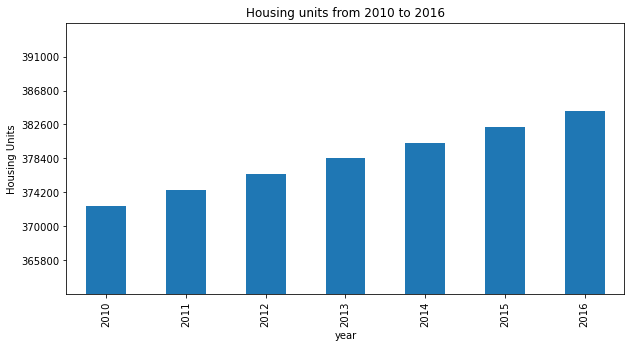

In [120]:
housing_units_per_year()

<AxesSubplot:title={'center':'Average Gross Rent by Year'}, xlabel='year', ylabel='Price per SqFt'>

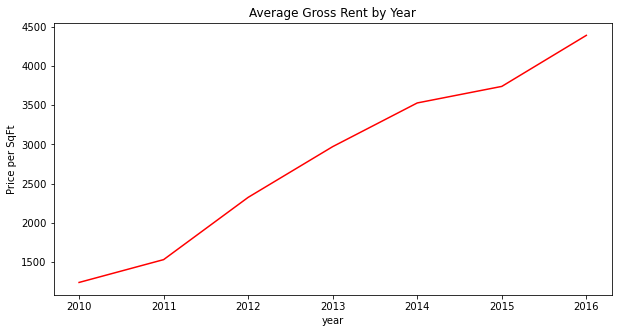

In [121]:
average_gross_rent()

<AxesSubplot:title={'center':'Average Price per sqFt by Year'}, xlabel='year', ylabel='Price per SqFt'>

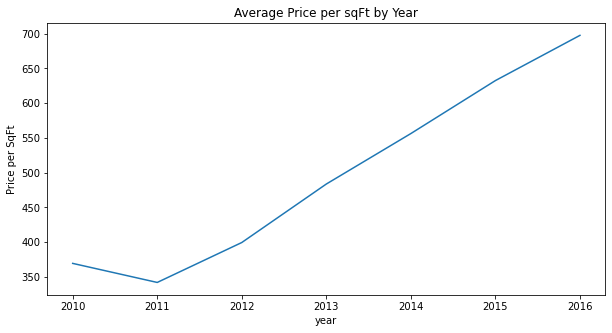

In [122]:
average_sales_price()

In [147]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [148]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [149]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

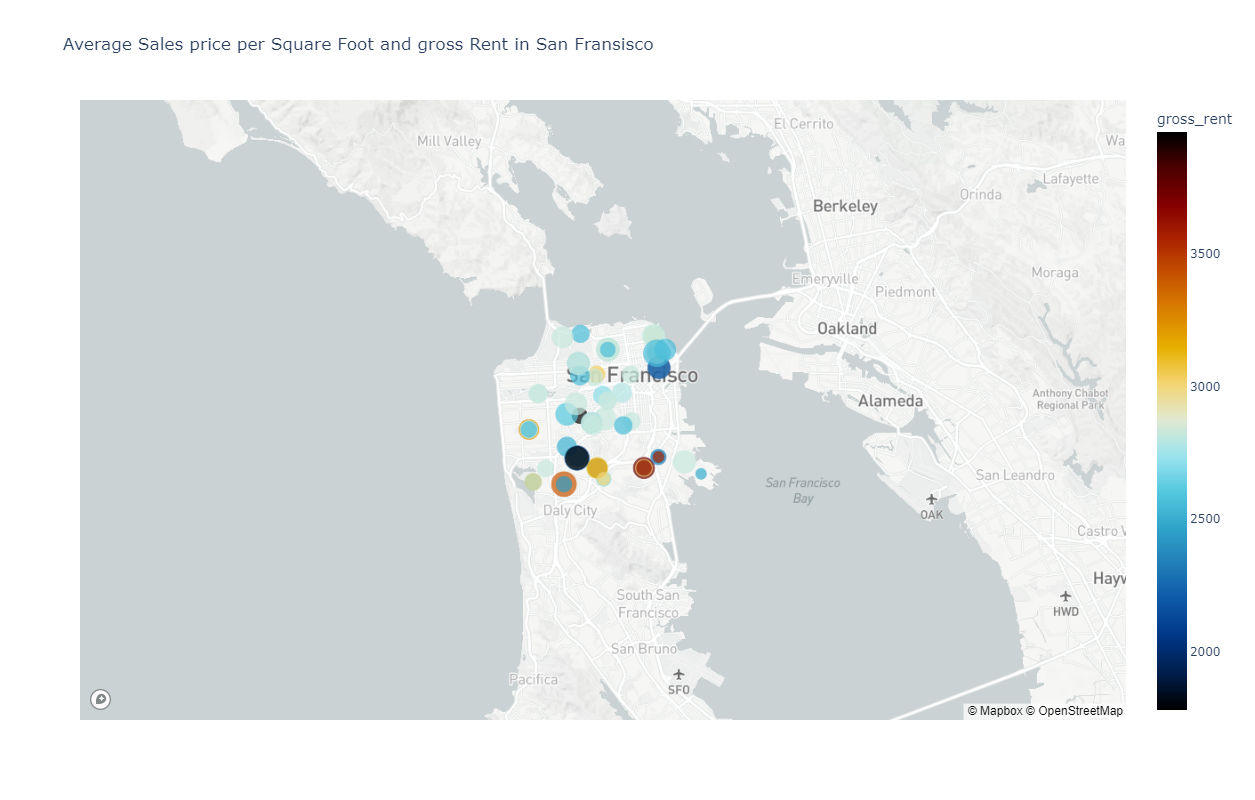

In [150]:
neighborhood_map().show()

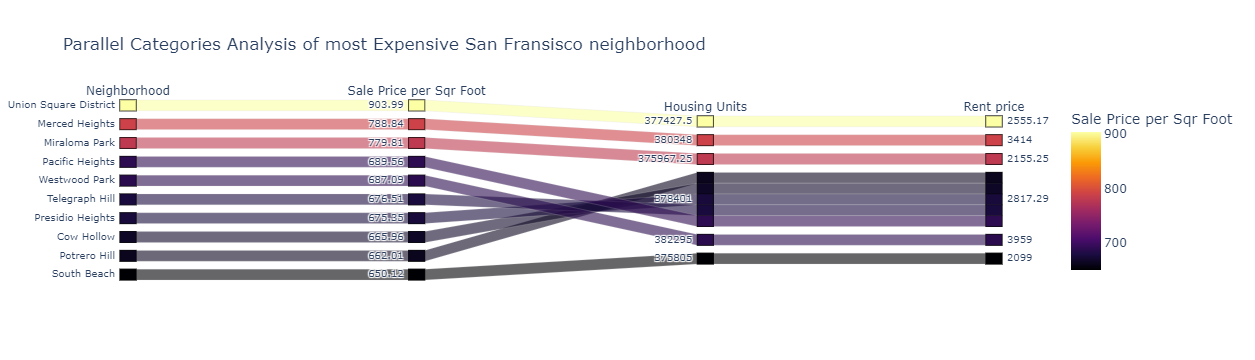

In [151]:
parallel_categories()

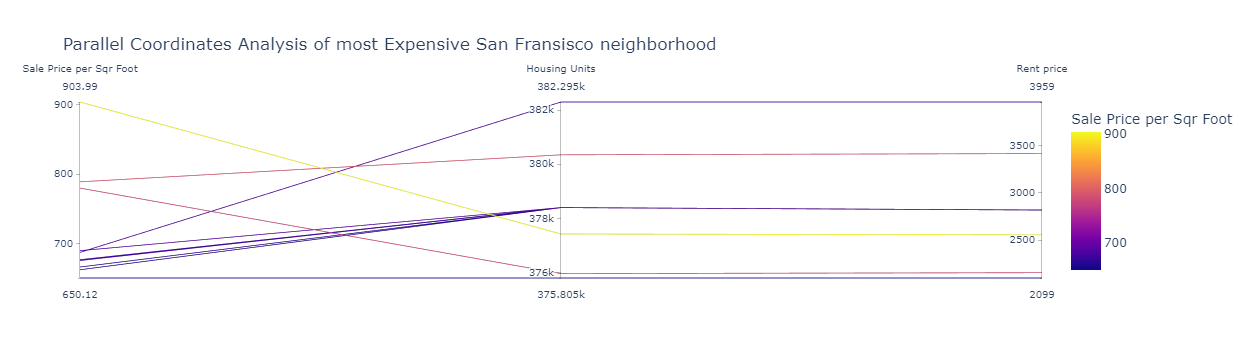

In [152]:
parallel_coordinates()

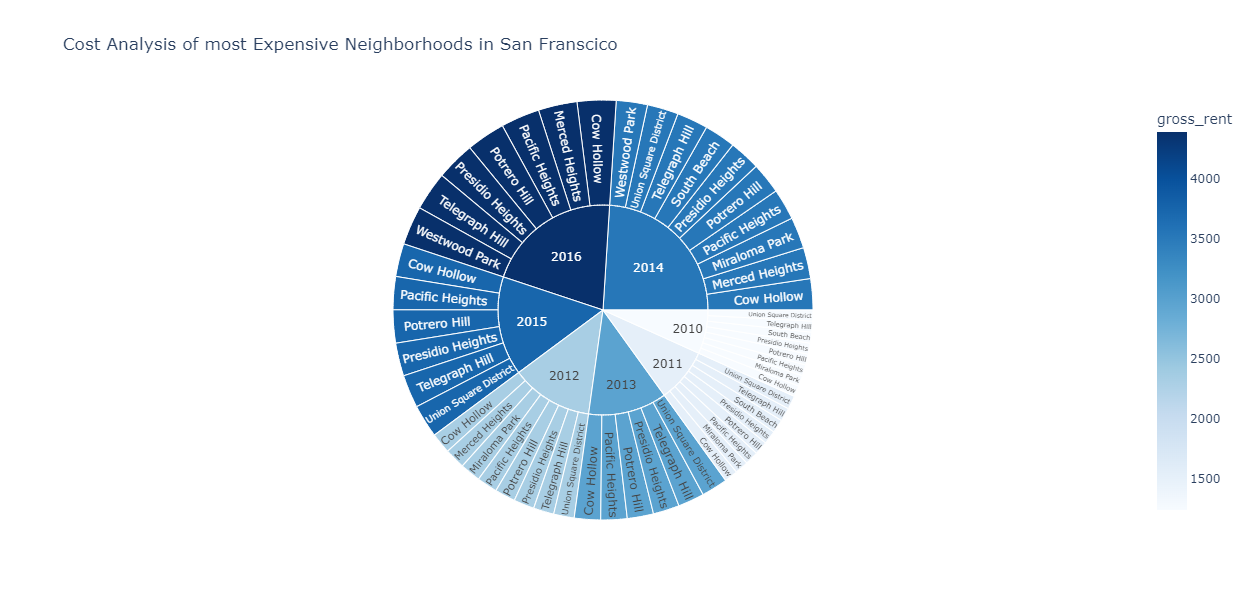

In [153]:
sunburst()